<a href="https://colab.research.google.com/github/eftekhari-mhs/population-protocols/blob/main/dynamic_counting/dynamic_counting_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A dynamic size counting protocol


In this notebook, we will focus on the dynamic size counting protocol of [this](https://arxiv.org/abs/2202.12864) paper. For a better understating of this notebook, we suggest you start by reading the paper.

The Java simulator of the protocol is also available on [Github](https://github.com/eftekhari-mhs/population-protocols/blob/main/dynamic_counting/). The simulator goes through 3 phases:
1) normal phase: happens during a normal computation of the protocol, when all the metrics that the agents store are proportional.
2) waiting phase: whan an agent realizes some discrepency between 2 or more of their fields, they move on to the waiting phase so that every agent catches the same discrepency.
3) updating phase: every agent generates a new geometric random variable and propagates the maximum by epidemic. Waiting phase is long enough so that with high pobability when an agent goes to the updating phase, the rest of the popuation are either in updating or waiting. hence there is no agent in the normal phase from the last round of computation with an old value of geometric random variable. Note that, throughout the notebook $n$ is the population size. 

The java simulator stores the snapshot in a JSON formatted file. For more information about the JSON representation of the agents read the [readme](https://github.com/eftekhari-mhs/population-protocols/blob/main/dynamic_counting/README.md) file. 

**To use this notebook, click on 'Runtime' and select 'Run all'**.

# Code for fetching data and creating plots

In [2]:
#@title Technical details: Loading JSON
import json
from types import SimpleNamespace
import io
import pandas as pd
import numpy as np
from numpy.random import randint

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt

from collections import defaultdict 

import requests

def load_file(description, flag=True, compressed_flag = False):
  if compressed_flag:
    url = 'https://raw.githubusercontent.com/eftekhari-mhs/scratch/main/compressed/dynamic_counting'
  else:
    url = 'https://raw.githubusercontent.com/eftekhari-mhs/scratch/main/dynamic_counting'
  filename = url+description+".json"  
  # print(filename)
  if flag:
    req = requests.get(filename)
    req = req.text
    # print(req)
    data = json.loads(req)
    # print(data)
  else:
    u = 'https://raw.githubusercontent.com/eftekhari-mhs/scratch/main/dynamic_'
    if compressed_flag:
      u = 'https://raw.githubusercontent.com/eftekhari-mhs/scratch/main/compressed/dynamic_'
    filename = u+description+".txt"  
    req=requests.get(filename).content
    data=pd.read_csv(io.StringIO(req.decode('utf-8')), delimiter=";|,|\[|\]",
                                      names=None, 
                                      header=None, 
                                      engine="python")


  return data

In [3]:
#@title Technical details: State Abtraction


from dataclasses import dataclass
from typing import Optional
import matplotlib as plt

from enum import Enum
class Phase(Enum):
  normal = 'normal'
  waiting = 'waiting'
  updating = 'updating'
   

@dataclass(frozen=True, eq= True)
class State:
  group: int
  grv: int
  fmv: int  
  phase: Phase
  est: int  

  def __hash__(self):
      return hash((self.group, self.grv))

In [4]:
#@title Technical details: Building dataframe for each field of an agent
#
#
#@markdown This section contains the functions that we use to retrieve data from JSON files. We make 
#@markdown a dataframe for each field of an agent to make the access easier. 
#
#@markdown There are two separate simulation results available in this notebook. 
#@markdown There are two different simulation results available in this notebook. One with a population size of 400000 in the presence of a dynamic adversary that shrinks the population down to 500. The shrinking happens in the middle of the simulation.
#@markdown The other with a population size of 10000 in the presence of a self-stabilizing adversary who starts the population in a uniformly random initial configuration.
#
#@markdown **To reveal the hidden code double click on this section.**
#

import math

group_key = "group"
rg_key = "grv"
fmv_key = "fmv"
est_key = "estimate"
phase_key = "phase"



original_size = "10000" #@param ["10000", "400000"] 
_N = int(original_size)
_LOG = round(math.log(_N)/math.log(2))
size_change = "dec" #@param ["dec"] 
array_mode = "regular" #@param ["regular"]

file_description = "_{}_{}".format(size_change,original_size)

print(f"n: {_N}; log(n): {_LOG}")     

data = load_file(file_description, compressed_flag= (array_mode=="compressed"))
# print(data)

#define columns for each dataframe based on possible values
def init_dataframe(field_name):  
  if field_name == rg_key:
    df = pd.DataFrame(columns=list(range(0, 21))) # should change based on the case  
  elif field_name == phase_key:
    df = pd.DataFrame(columns=[p for p in Phase])
  elif field_name == group_key:
    df = pd.DataFrame(columns=list(range(0, 40))) # should change based on the case  
  elif field_name == est_key:
    df = pd.DataFrame(columns=list(range(0, 21))) # should change based on the case  
  elif field_name == fmv_key:
      if array_mode=="compressed":
        df = pd.DataFrame(columns=list(range(0, 8)))
      else:
        df = pd.DataFrame(columns=list(range(0, 40)))
  else:
    print("unexpected value")
    df = pd.DataFrame()
  return df

def build_dict(field_name, all_states):
  new_row = defaultdict(int) 
  for state, count in all_states.items(): # Iterates through the pairs of state and count
    if field_name == rg_key:
      new_row[state.grv]+=count
    if field_name == phase_key:
      new_row[state.phase]+=count
    if field_name == group_key:
      new_row[state.group]+=count
    if field_name == fmv_key:
      new_row[state.fmv]+=count
    if field_name == est_key:
      new_row[state.est]+=count        
  return new_row


def build_dataframe(field_name):   
  t = 0 
  df = init_dataframe(field_name)
  for tikz,statesList in data["interactions"].items():     
    all_states = defaultdict(lambda: 0) #dict()    
    for state, count in statesList:
      grv = state[rg_key]            
      group = state[group_key]
      fmv = state[fmv_key]
      est = state[est_key]
      phase = Phase(state[phase_key])
      
      result = State(grv = grv, phase = phase, group = group, fmv = fmv, est = est)
      all_states[result] += count      
    
    df.loc[t] = build_dict(field_name, all_states)
    t+=1
  df = df.fillna(0)
  
  return df

n: 10000; log(n): 13


In [24]:
#@title Technical details: Plotting functions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

def state_bar_plot(data, time, l = 40, yscale = "linear"):
  # print(data)
  dist = [data[i][time] for i in range(1, l)]
  plt.figure(figsize=(12,6))
  plt.bar(range(1, l),dist)
  # plt.ylim(ymax = 3500, ymin = 1)
  plt.title(f"Time step {time}, n = {original_size}")
  
  plt.yscale(yscale)  
  plt.show()

In the following code block, we will use the ``build_datafram(fieldname)`` function on ``fmv_key`` to generate a dataframe that shows the changes of fmv (first missing value) in the agents over the course of a simulation. 
``fmv`` represents the index of the first group with signal = 0. 

Each element in this dataframe represents the count of specific agents in the whole popualtion. For example, element(i, j) shows how many agents after $i$ interactions have their phase field equal to $j$. 



In [6]:
#@title Initialize one dataframe as example
max_yaxis = _N * (1.1) # for all plots

#load the fmv data frames
df_fmv = build_dataframe(fmv_key)
df_fmv

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1354,29,5,7,11,6,21,7,7,3,...,0,0,0,1,1,0,0,0,0,8517
2,215,6,1,1,0,3,0,0,0,2,...,0,0,0,1,0,0,0,0,0,9765
3,34,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9965
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We could use a similar code ``build_datafram(phase_key)`` to generate a dataframe that shows the changes on ``phase``. 
As mentioned earlier, the phase field could have three different values: normal, waiting, and updating. 

In [8]:
df_phase = build_dataframe(phase_key)
print(df_phase.columns)

Index([Phase.normal, Phase.waiting, Phase.updating], dtype='object')


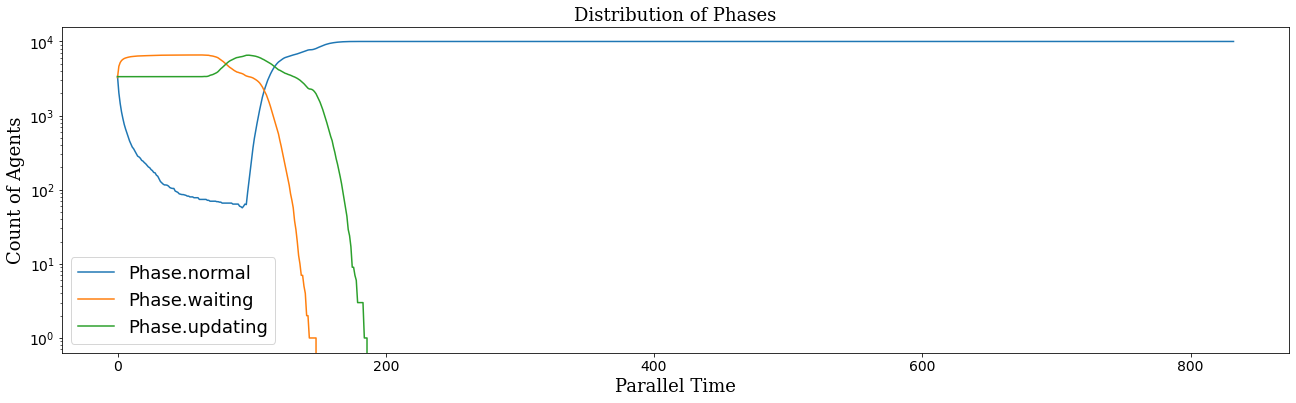

In [9]:
# colors = ['b', 'r', 'g', 'c', 'm', 'y','k']
font_large = {'family': 'serif',
          'color':  'black',
          'weight': 'normal',
          'size': 18,
          }

ax = df_phase.plot(figsize = (22,6),logy=True)

ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
ax.set_title("Distribution of Phases", fontdict= font_large)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
ax.legend(prop={'size': 18})

fig = ax.get_figure()
fig.savefig('phases.svg')
fig.savefig('phases.pdf')

Finally, we generate a dataframe to store changes to agents' ``output`` value. 

In [10]:
df_output = build_dataframe(est_key)
df_output

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,110,111,104,96,94,91,90,109,123,87,...,115,84,101,98,100,135,99,103,105,113
1,822,111,104,96,93,91,90,109,122,87,...,115,84,101,98,100,135,99,103,105,113
2,1220,111,104,96,93,91,90,109,122,87,...,114,84,101,98,100,135,99,103,105,113
3,1466,111,104,96,93,91,90,109,122,87,...,114,84,101,98,100,135,99,103,105,114
4,1636,111,104,96,93,91,90,109,122,87,...,114,84,101,98,100,135,99,103,105,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10000,0,0,0
829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10000,0,0,0
830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10000,0,0,0
831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10000,0,0,0


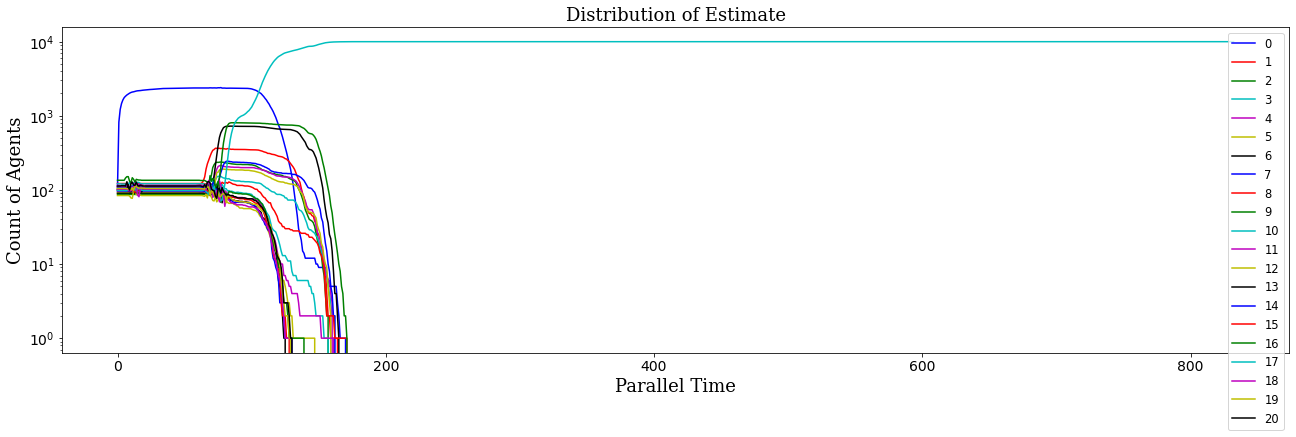

In [11]:
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'r', 'g', 'c', 'm', 'y','k']
ax = df_output.plot(figsize = (22,6), logy=True, color=colors)
ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
ax.set_title("Distribution of Estimate", fontdict= font_large)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
ax.legend(prop={'size': 11.5})

fig = ax.get_figure()
fig.savefig('est.svg')
fig.savefig('est.pdf')

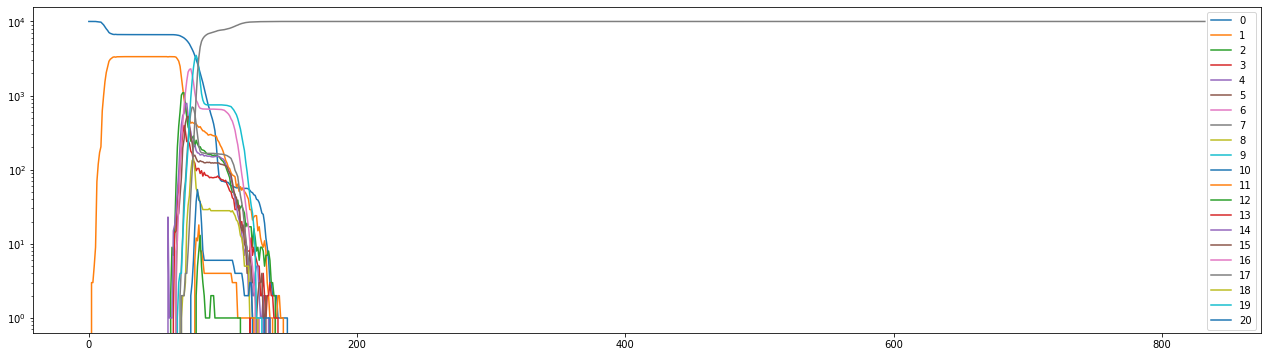

In [12]:
df_rg = build_dataframe(rg_key)
df_rg.plot(figsize = (22,6), logy=True)


In [22]:
#@markdown uncomment the following line for random initial setting on population size : 1000000
# original_size = 1000000 
limit = 40


# getting the distribution of the group values across the population
df_groups = load_file("clock_inits_{}".format(original_size), False, False)


df_groups.drop(df_groups.columns[[0,limit]], axis=1, inplace=True)
df_groups.columns = range(df_groups.shape[1])

df_signals = load_file(f"clock_signals_{original_size}", False, False)

df_signals.drop(df_signals.columns[[0,limit]], axis=1, inplace=True)
df_signals.columns = range(df_signals.shape[1])


In [25]:
interact(state_bar_plot, data = fixed(df_groups), time = widgets.IntSlider(min=0, max=len(df_groups), step=1, value=0) , yscale = ["linear", "log"])

interactive(children=(IntSlider(value=0, description='time', max=832), IntSlider(value=40, description='l', ma…

<function __main__.state_bar_plot>

In [27]:
df_signals

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,13,0,0,0,0,0,0,0,0,3,...,0,1,4,1,11,3,0,1,2,NaN
4,13,0,0,0,1,2,0,7,5,3,...,33,4,22,5,15,29,49,6,15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,13,1,4,7,10,13,16,19,22,25,...,0,0,0,0,0,0,0,0,0,NaN
828,13,2,4,7,10,13,16,19,22,25,...,0,0,0,0,0,0,0,0,0,NaN
829,13,1,4,7,10,13,16,19,22,25,...,0,0,0,0,0,0,0,0,0,NaN
830,13,1,4,7,10,12,16,19,22,25,...,0,0,0,0,0,0,0,0,0,NaN


In [28]:
interact(state_bar_plot, data = fixed(df_signals), time = widgets.IntSlider(min=0, max=len(df_signals), step=1, value=0) , yscale = ["linear", "log"])

interactive(children=(IntSlider(value=0, description='time', max=832), IntSlider(value=40, description='l', ma…

<function __main__.state_bar_plot>

In [ ]:
# @title save an snapshot at a give time t
def save_fig(df, t, name):
    dist = [df[i][t] for i in range(1, limit)]
    plt.figure(figsize=(12,6))
    plt.bar(range(1, limit),dist)
    plt.title(f"Time step {t}, n = {original_size}",fontsize=22)
    plt.xlabel(name, fontsize=18)
    plt.ylabel('number of agents', fontsize=18)
    plt.yscale('log')  
    # ax = df_output.plot(figsize = (22,6), logy=True, color=colors)
    # ax.set_xlabel("Parallel Time", fontdict= font_large)
    # ax.set_ylabel("Count of Agents", fontdict= font_large)
    # ax.set_title("Distribution of Estimate", fontdict= font_large)
    plt.xticks(fontsize= 18)
    plt.yticks(fontsize= 18)
    
    # plt.show()
    # export files
    plt.savefig(f"{name}_t{t}.svg")
    plt.savefig(f"{name}_t{t}.pdf")

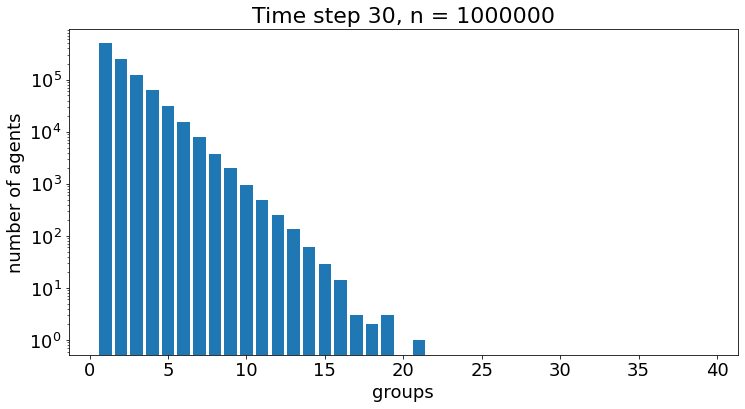

In [ ]:
save_fig(df_groups, t = 30, name= 'groups')

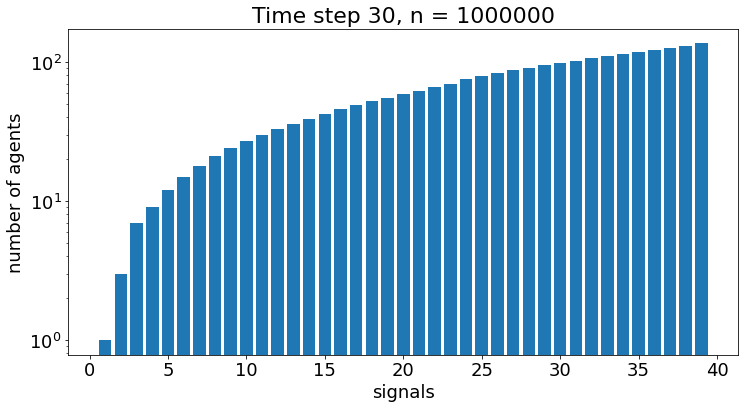

In [ ]:
save_fig(df_signals, t = 30, name= 'signals')

### Pseudocode (dynamic size counting)



```
initial values: (c_i values are constants)
G = 0
SG = 1
all_clocks = []
round = 1
output = 0
timer = 0
missing_clock = 0 # storing the "first" clock value that is zero



# generate a new Stationary G at every interaction:
if random.choice([True, False]):
    SG += 1
else: 
    SG = 1

# reset count down on array
for i in range(1, len(all_clocks)):
    max_i = max(all_clocks[i], other.all_clocks[i])
    all_clocks[i] = other.all_clocks[i] = max(0, max_i - 1)

all_clocks[SG] = SG*c1
other.all_clocks[SG] = SG*c1
all_clocks[other.SG] = other.SG*c1
other.all_clocks[other.SG] = other.SG*c1
      
# update missing index
missing_clock = len(all_clocks)
# t1 is a threshold to avoid smaller ones (about log log n)
for i in range(t1, len(all_clocks)): 
    if all_clocks[i] == 0:
        missing_clock = i
        break


# check for discrepancy between SG clocks and current output
if timer == 0:
    if missing_clock < output - c3 or missing_clock > output +c3:
        timer = 1 #wake up call --> green mode

# TODO : fix this
if timer > 0 and round == 1:
    if missing_clock < old_missing_clock-c3: (or maybe if missing_clock > old_missing_clock)
        timer = 1 #wake up call






# internal timer: an agent starts counting via timer field if she observes 
# discrepancy between missing SG clock and the current output
# in round 1, the agent wait for other agents to see the same discrepancy
# in round 2, the agent generate a new GRV and propagates the max by epidemic


# example n = 2^12 --> n' = 2^5
# output = 12, missing_value = 6


# in round 1 if two agents with different output values meet --> err

if timer > 0: # intial value is one, default is zero
    timer+= 1

if timer >= c2*missing_clock: #what if the population size changes twice, from 1000--> 100 --> 10 (maybe they should reset their timer and start counting from zero for new missing clock value: 5)
after 100 time: 2n/3 agents who saw missing value 100
now 100 --> 10 (those n/3 who didn't notice anything start counting up to c*10) but the rest (2n/3) agents are in the next round

    if round == 1:
        G = new_geometric_random_var() # number of coin flips until head
        round = 2 
        timer = 1        
    elif round == 2:
        output = G
        round = 1        
        timer = 0 #sleep until see a discrepancy

# propagate maximum G by epidemic in round 2
if G < other.G and [(other.round == round and round == 2) 
or (round =2 and other.timer = 0) 
or (timer == 0 and other.timer == 0)]:
    G = other.G

```




#PPSIM simulation results - Group Values

In [16]:
#@title install ppsim
!pip install ppsim

# from ppsim import Simulation, StatePlotter, time_trials
# from dataclasses import dataclass
# import ipywidgets as widgets
# from matplotlib import pyplot as plt
# import numpy as np

     |████████████████████████████████| 221 kB 7.1 MB/s 
     |████████████████████████████████| 15.3 MB 23.9 MB/s 
  Created wheel for ppsim: filename=ppsim-0.1.6-cp37-cp37m-linux_x86_64.whl size=509675 sha256=f3d7005ac5608f03cc023476bf8eaf18a95f6de20c9f09b139cb0950a7435cd3
  Stored in directory: /root/.cache/pip/wheels/6c/be/4c/16f6ee96fb5bb9e2d422b11bab8f1e4d4a4f1234c3f89c332d
Successfully built ppsim
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 wh

In [17]:
from ppsim import Simulation, StatePlotter, time_trials
from dataclasses import dataclass
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np

ImportError: ignored

In [ ]:
# @title O(log n) states generating dynamic groups

#@markdown 

#@markdown 
#@markdown

m = 40
from dataclasses import dataclass, field

@dataclass(unsafe_hash=True)
class Agent:    
    group: int = 0            #values = {0, 1, 2, ... , 8 log n} w.v.h.p.
    turn: bool = True
    signals: list = field(default_factory=lambda:[0] * 40)# [0] * 40
    # -> lambda expression

# Code to plot the configuration of Agents
def plot_row(df, row, yscale='linear'):
    fig, ax = plt.subplots(figsize=(12,5))
    df.iloc[row].unstack().plot(ax=ax, kind='bar', 
                              ylim=(0,n))
    ax.set_yscale(yscale)

# # The constant state dissemination paper
# def dynamic_group(a: Agent, b: Agent, limit: int):    
#     return {
#             (a, Agent(group = min(b.group + 1, limit))): 1/2,             
#             (a, Agent(group = 1)): 1/2
#            }

           

In [ ]:
# The dynamic signaling
def dynamic_group(a: Agent, b: Agent, limit: int):    
  if a.turn and b.turn: 
    a.turn = False
    b.turn = False         
    return {
            (a, Agent(group = min(b.group + 1, limit))): 1/2,             
            (a, Agent(group = 1)): 1/2
           }
  elif not (a.turn or b.turn):
    a.turn = True
    b.turn = True
    a.signals.insert(a.group, a.group * 3 + 1) # index,value
    b.signals.insert(b.group, b.group * 3 + 1)
    for i in range(m):
      a.signals[i] = b.signals[i] = max(0, max(a.signals[i]-1,b.signals[i]-1))

In [ ]:
n = 10 ** 6
space_limit = 40;
# Start with all in group 1
init_config = {Agent(group = 1):n}#, Agent(group = 10):n/4, Agent(group = 20):n/4}
sim = Simulation(init_config, dynamic_group, limit = space_limit)#, transition_order='asymmetric')

sim.run(20 * int(np.log(n)))
df_hist = sim.history
# df_hist.reset_index(drop=True, inplace=True)
df_hist.columns = [str(x) for x in range(0,space_limit)]
df_hist.columns = range(len(df_hist.columns))
df_hist

In [ ]:
def group_bar_plot(data, time, yscale = "log"):
  # print(data)
  dist = [data[i][time] for i in range(1, space_limit)]
  plt.figure(figsize=(12,6))
  plt.bar(range(1, space_limit),dist)
  plt.title(f"Time step {time}, n = {data[0][0]}")
  
  plt.yscale(yscale)  
  plt.show()

interact(group_bar_plot, data = fixed(df_hist), time = widgets.IntSlider(min=0, max=len(df_hist), step=1, value=0), yscale = ["linear", "log"])

In [ ]:
# @title save an snapshot at a give time t
t = 300

dist = [df_hist[i][t] for i in range(1, space_limit)]
plt.figure(figsize=(12,6))
plt.bar(range(1, space_limit),dist)
plt.title(f"Time step {t}, n = {df_hist[0][0]}")
  
plt.yscale('log')  
# plt.show()
# export files
plt.savefig('dynamic_grouping.svg')
plt.savefig('dynamic_grouping.pdf')